#Predicting Road Accident Risk

##05 — Deep Learning: Base MLP Modeli

Proje Ekibi:

Esmanur Ulu - 231101024

Nehir Tıraş - 231101065

Zeynep Yetkin - 231101042

Amaç

Bu notebook, proje planının Derin Öğrenme (Deep Learning) ayağını başlatmaktadır. Önceki aşamada klasik modellerle elde edilen rekabetçi skoru (RMSE ≈0.0561) baz alarak, PyTorch ile Çok Katmanlı Algılayıcı (MLP) mimarisinin temelini atılacaktır.

Bu Aşamadaki Hedefler:

PyTorch kütüphanesini kullanarak temel bir MLP model mimarisi (nn.Module) kurmak.

Eğitim sürecini başlatmak ve temel modelin hata oranını (RMSE) belirlemek.

Modelin eğitim performansını (Loss) ve hata trendini (RMSE) grafiklerle görselleştirmek.

Elde edilen en iyi modeli, bir sonraki aşama olan hiperparametre optimizasyonu (Notebook 6) için kaydetmek.

#1. Kütüphaneler, Drive Bağlantısı ve Veri Hazırlığı

Veri işleme hattının (Pipeline) başlangıcı olan Notebook 1'de temizlenen ve ölçeklenen verileri (processed/ klasöründen) yüklüyoruz. Ardından bu verileri, PyTorch'un gerektirdiği Tensör formatına dönüştürerek mini-batch eğitimi için DataLoader nesnelerini oluşturuyoruz.

In [ ]:
# Gerekli Kütüphaneler
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch ve Model Kütüphaneleri
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Metrik Hesaplama
from sklearn.metrics import mean_squared_error

# Google Drive Bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# Proje Yolları Tanımı
# DİKKAT: Lütfen Kendi Ana Klasörünüzle Kontrol Edin
base_path = '/content/drive/MyDrive/YAP470_Proje'
processed_path = os.path.join(base_path, 'processed')
models_path = os.path.join(base_path, 'models')
os.makedirs(models_path, exist_ok=True)

# -------------------------------------------------------------
## Verilerin Yüklenmesi ve Tensöre Dönüştürülmesi (Hata Düzeltmesi Dahil)
# -------------------------------------------------------------
print(f"Veri setleri '{processed_path}' klasöründen yükleniyor...")
X_train_df = pd.read_csv(os.path.join(processed_path, 'X_train_processed.csv'))
y_train_df = pd.read_csv(os.path.join(processed_path, 'y_train.csv'))
X_val_df = pd.read_csv(os.path.join(processed_path, 'X_val_processed.csv'))
y_val_df = pd.read_csv(os.path.join(processed_path, 'y_val.csv'))

# Giriş (Feature) Sayısı
input_size = X_train_df.shape[1]

# Verileri float32 Tensörlere Çevirme
X_train_tensor = torch.tensor(X_train_df.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_df.values, dtype=torch.float32)

# HEDEF DEĞERLERİN KESİN (N, 1) ŞEKLİNDE BOYUTLANDIRILMASI (ÖNCEKİ HATA DÜZELTİLDİ)
y_train_tensor = torch.tensor(y_train_df.values, dtype=torch.float32).reshape(-1, 1)
y_val_tensor = torch.tensor(y_val_df.values, dtype=torch.float32).reshape(-1, 1)

# DataLoader Oluşturma (Batch Size: 128)
BATCH_SIZE = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Cihaz Seçimi (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nVeri Yükleme Tamamlandı. Giriş Boyutu: {input_size}. Cihaz: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Veri setleri '/content/drive/MyDrive/YAP470_Proje/processed' klasöründen yükleniyor...

Veri Yükleme Tamamlandı. Giriş Boyutu: 20. Cihaz: cpu


#2. Çok Katmanlı Algılayıcı (MLP) Mimarisi

Deep Learning modelleri, torch.nn.Module sınıfından türetilen özel bir mimariye sahiptir. Bu temel modelde, iki gizli katman ve doğrusal olmayan ilişkileri yakalamak için ReLU aktivasyon fonksiyonu kullanılmıştır. Çıkış katmanında aktivasyon kullanılmaması, standart bir regresyon mimarisini işaret eder.

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size):
        super(SimpleMLP, self).__init__()

        # 1. Gizli Katman (128 Nöron)
        self.fc1 = nn.Linear(input_size, 128)

        # 2. Gizli Katman (64 Nöron)
        self.fc2 = nn.Linear(128, 64)

        # 3. Çıkış Katmanı (1 Nöron: Risk Skoru)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        # ReLU aktivasyonları
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Çıkış katmanı (Regresyon)
        out = self.fc3(x)
        return out

# Modeli Oluşturma
model = SimpleMLP(input_size).to(device)
print("\n--- Kurulan Temel MLP Mimarisi ---")
print(model)


--- Kurulan Temel MLP Mimarisi ---
SimpleMLP(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


#3. Eğitim Döngüsü ve Değerlendirme

Modeli eğitmek için Ortalama Karesel Hata (MSE) kayıp fonksiyonu ve yaygın olarak kullanılan Adam optimizasyon algoritması seçilmiştir. Eğitimin her adımında modelin Validation (Doğrulama) RMSE skoru hesaplanarak en iyi ağırlıklar (mlp_base.pth) kaydedilir.

In [ ]:
# Hyperparametreler
LEARNING_RATE = 0.001
EPOCHS = 30

# Kayıp Fonksiyonu (Mean Squared Error)
criterion = nn.MSELoss()

# Optimizasyon Algoritması
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# RMSE Hesaplama Fonksiyonu
def evaluate_rmse(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            total_loss += criterion(outputs, y_batch).item() * X_batch.size(0)

            predictions.extend(outputs.cpu().numpy().flatten())
            targets.extend(y_batch.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader.dataset)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    return avg_loss, rmse

# -------------------------------------------------------------
## Model Eğitimi Başlatılıyor
# -------------------------------------------------------------
print("\n--- Model Eğitimi Başlıyor ---")
train_losses = []
val_rmses = []
best_val_rmse = float('inf')

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_rmse = evaluate_rmse(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_rmses.append(val_rmse)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.6f}, Val RMSE: {val_rmse:.4f}")

    # En iyi modeli kaydetme
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), os.path.join(models_path, 'mlp_base.pth'))

print("\n--- Eğitim Tamamlandı ---")


--- Model Eğitimi Başlıyor ---
Epoch [1/30], Train Loss: 0.004127, Val RMSE: 0.0579
Epoch [2/30], Train Loss: 0.003347, Val RMSE: 0.0577
Epoch [3/30], Train Loss: 0.003312, Val RMSE: 0.0575
Epoch [4/30], Train Loss: 0.003289, Val RMSE: 0.0577
Epoch [5/30], Train Loss: 0.003270, Val RMSE: 0.0584
Epoch [6/30], Train Loss: 0.003257, Val RMSE: 0.0571
Epoch [7/30], Train Loss: 0.003254, Val RMSE: 0.0571
Epoch [8/30], Train Loss: 0.003245, Val RMSE: 0.0570
Epoch [9/30], Train Loss: 0.003241, Val RMSE: 0.0572
Epoch [10/30], Train Loss: 0.003235, Val RMSE: 0.0573
Epoch [11/30], Train Loss: 0.003232, Val RMSE: 0.0569
Epoch [12/30], Train Loss: 0.003228, Val RMSE: 0.0569
Epoch [13/30], Train Loss: 0.003224, Val RMSE: 0.0574
Epoch [14/30], Train Loss: 0.003221, Val RMSE: 0.0570
Epoch [15/30], Train Loss: 0.003219, Val RMSE: 0.0570
Epoch [16/30], Train Loss: 0.003216, Val RMSE: 0.0569
Epoch [17/30], Train Loss: 0.003212, Val RMSE: 0.0569
Epoch [18/30], Train Loss: 0.003211, Val RMSE: 0.0570
Epoch

#4. Sonuçların Görselleştirilmesi ve Analizi

Modelin eğitim trendi, hata dağılımı ve tahmin doğruluğu detaylı grafiklerle analiz edilir.


--- Final Model Yükleniyor ve Değerlendiriliyor ---
Başarıyla yüklenen en iyi Val RMSE: 0.0569


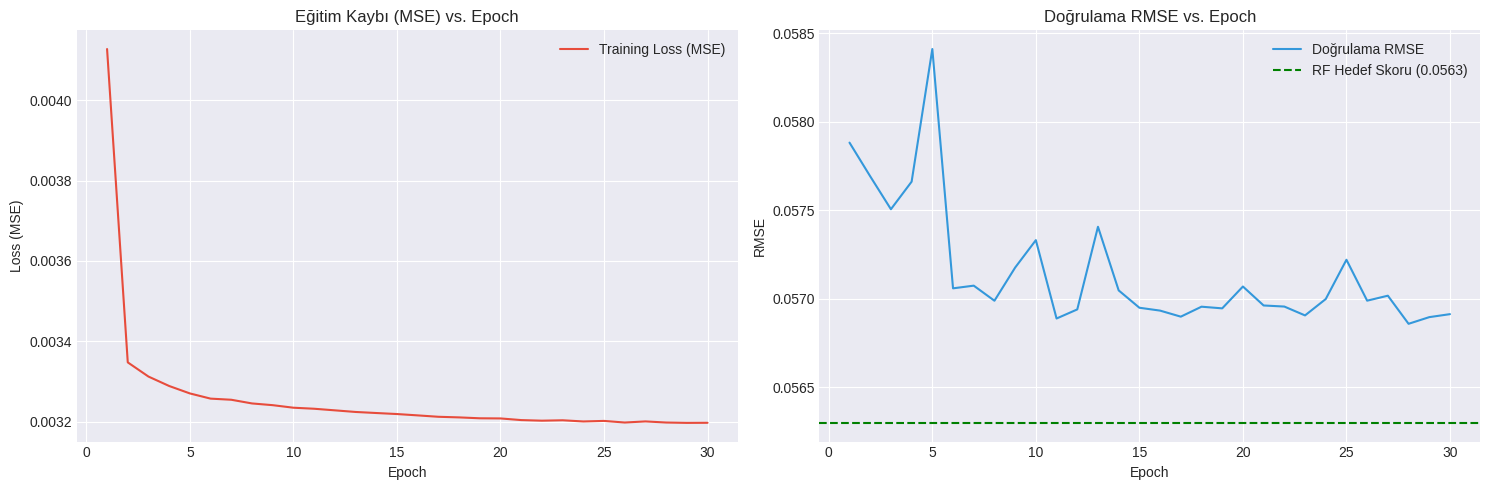

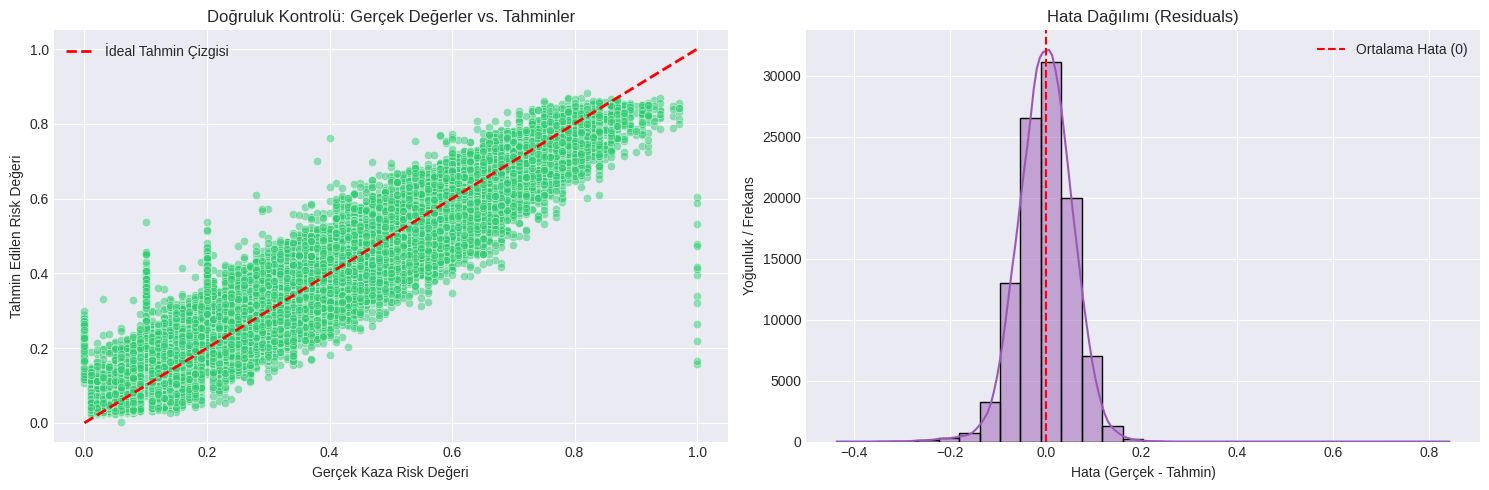

In [ ]:
# -------------------------------------------------------------
## En İyi Modeli Yükle ve Final Tahminleri Al
# -------------------------------------------------------------
print("\n--- Final Model Yükleniyor ve Değerlendiriliyor ---")
# Notebook 3 ve 4'ten gelen rekorlar:
RF_TARGET_RMSE = 0.0563    # Random Forest (NB3)
XGB_TARGET_RMSE = 0.0562   # XGBoost (NB4)
ENSEMBLE_LEAD = 0.0561     # Klasik ML Rekoru (Ensemble)

final_model = SimpleMLP(input_size).to(device)
try:
    final_model.load_state_dict(torch.load(os.path.join(models_path, 'mlp_base.pth'), map_location=device))
    print(f"Başarıyla yüklenen en iyi Val RMSE: {best_val_rmse:.4f}")
except:
    # Hata durumunda, en son eğitilen modeli kullan
    print("Kaydedilmiş model bulunamadı. Son epoch modeli kullanılıyor.")
    final_model = model
    best_val_rmse = val_rmses[-1]

final_model.eval()

# Tahminleri topla
y_test_pred = []
y_test_true = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = final_model(X_batch)
        y_test_pred.extend(outputs.cpu().numpy().flatten())
        y_test_true.extend(y_batch.cpu().numpy().flatten())

y_test_pred = np.array(y_test_pred)
y_test_true = np.array(y_test_true)
residuals = y_test_true - y_test_pred

# -------------------------------------------------------------
## GRAFİK SETİ 1: Eğitim Trendi (Loss ve RMSE Eğrileri)
# -------------------------------------------------------------
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sol Grafik: Training Loss
axes[0].plot(range(1, EPOCHS + 1), train_losses, label='Training Loss (MSE)', color='#e74c3c')
axes[0].set_title('Eğitim Kaybı (MSE) vs. Epoch')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()

# Sağ Grafik: Validation RMSE
axes[1].plot(range(1, EPOCHS + 1), val_rmses, label='Doğrulama RMSE', color='#3498db')
axes[1].axhline(y=RF_TARGET_RMSE, color='g', linestyle='--', label=f'RF Hedef Skoru ({RF_TARGET_RMSE:.4f})')
axes[1].set_title('Doğrulama RMSE vs. Epoch')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('RMSE')
axes[1].legend()

plt.tight_layout()
plt.show()

# -------------------------------------------------------------
## GRAFİK SETİ 2: Analitik Doğrulama (Hata Analizi)
# -------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sol Grafik: Gerçek Değerler vs. Tahminler
sns.scatterplot(x=y_test_true, y=y_test_pred, alpha=0.5, color='#2ecc71', ax=axes[0])
min_val = min(y_test_true.min(), y_test_pred.min())
max_val = max(y_test_true.max(), y_test_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='İdeal Tahmin Çizgisi')
axes[0].set_title('Doğruluk Kontrolü: Gerçek Değerler vs. Tahminler')
axes[0].set_xlabel('Gerçek Kaza Risk Değeri'); axes[0].set_ylabel('Tahmin Edilen Risk Değeri')
axes[0].legend()

# Sağ Grafik: Hata Dağılımı (Residuals)
sns.histplot(residuals, kde=True, color='#9b59b6', bins=30, ax=axes[1])
axes[1].axvline(0, color='red', linestyle='--', label='Ortalama Hata (0)')
axes[1].set_title('Hata Dağılımı (Residuals)')
axes[1].set_xlabel('Hata (Gerçek - Tahmin)'); axes[1].set_ylabel('Yoğunluk / Frekans')
axes[1].legend()

plt.tight_layout()
plt.show()

#5. Kapsamlı Analiz ve İleri Adım Planı

Bu aşamada, temel MLP modelimizden elde edilen sonuçları projenin önceki aşamalarıyla (Klasik ML) kıyaslıyor ve Derin Öğrenme stratejimizin başarısını ölçüyoruz. Eğitimden elde edilen en iyi Validasyon RMSE skoru: 0.0569 olarak belirlenmiştir.

A. Model Karşılaştırmalı Analizi ve Sıralaması

Derin öğrenme modelimizin konumunu belirlemek için, proje boyunca kullanılan tüm regresyon modelleri, elde ettikleri Validation RMSE skorlarına göre karşılaştırılmıştır.

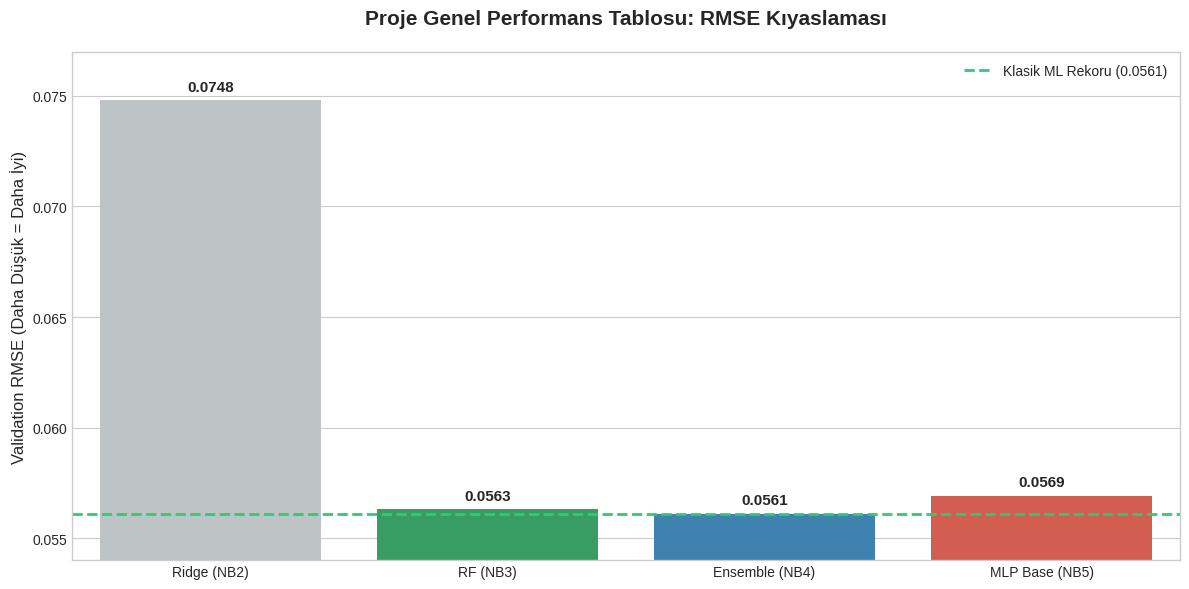


             TÜM MODELLERİN KARŞILAŞTIRMALI ÖZETİ
| Model Mimarisi   | Kullanılan Notebook   |   Validation RMSE | Durum    |
|:-----------------|:----------------------|------------------:|:---------|
| Ensemble (NB4)   | NB 04                 |            0.0561 | Lider    |
| RF (NB3)         | NB 03                 |            0.0563 | Takipte  |
| MLP Base (NB5)   | NB 05                 |            0.0569 | Takipte  |
| Ridge (NB2)      | NB 02                 |            0.0748 | Referans |


In [ ]:
# --- Gerekli Kütüphaneler ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Güncel Model Skorları (Notebook 1-5 Final Verileri) ---
RIDGE_RMSE = 0.0748        # NB2: Baseline
RF_RMSE = 0.0563           # NB3: Random Forest Champion
XGB_ENSEMBLE_RMSE = 0.0561 # NB4: Klasik ML Rekoru (Ensemble)
MLP_BASE_RMSE = 0.0569     # NB5: Sizin şu an elde ettiğiniz skor

model_names = ['Ridge (NB2)', 'RF (NB3)', 'Ensemble (NB4)', 'MLP Base (NB5)']
rmse_scores = [RIDGE_RMSE, RF_RMSE, XGB_ENSEMBLE_RMSE, MLP_BASE_RMSE]

# -------------------------------------------------------------
# 1. PERFORMANS KIYASLAMA GRAFİĞİ
# -------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))

# Barların oluşturulması
colors = ['#BDC3C7', '#27AE60', '#2E86C1', '#E74C3C'] # Gri, Yeşil, Mavi, Kırmızı
ax = sns.barplot(x=model_names, y=rmse_scores, palette=colors, hue=model_names, legend=False)

# Klasik ML Rekoru Çizgisi (Hedef Hattı)
plt.axhline(y=XGB_ENSEMBLE_RMSE, color='#2ECC71', linestyle='--', linewidth=2,
            label=f'Klasik ML Rekoru ({XGB_ENSEMBLE_RMSE:.4f})')

# Barların üzerine değerlerin yazılması
for i, v in enumerate(rmse_scores):
    ax.text(i, v + 0.0003, f"{v:.4f}", ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.title('Proje Genel Performans Tablosu: RMSE Kıyaslaması', fontsize=15, fontweight='bold', pad=20)
plt.ylabel('Validation RMSE (Daha Düşük = Daha İyi)', fontsize=12)
plt.ylim(0.054, 0.077) # Odaklanmış ölçek
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 2. AKADEMİK ÖZET TABLOSU
# -------------------------------------------------------------
comparison_df = pd.DataFrame({
    'Model Mimarisi': model_names,
    'Kullanılan Notebook': ['NB 02', 'NB 03', 'NB 04', 'NB 05'],
    'Validation RMSE': rmse_scores
}).sort_values(by='Validation RMSE')

comparison_df['Durum'] = comparison_df['Validation RMSE'].apply(
    lambda x: 'Lider' if x == min(rmse_scores) else ('Takipte' if x < 0.06 else 'Referans')
)

print("\n" + "="*60)
print("             TÜM MODELLERİN KARŞILAŞTIRMALI ÖZETİ")
print("="*60)
print(comparison_df.to_markdown(index=False, floatfmt=".4f"))
print("="*60)

B. Bulguların Sentezi ve Derin Öğrenme Teşhisi

Klasik ML Duvarı ve MLP Potansiyeli: Klasik topluluk modellerinin (Ensemble: 0.0561) ulaştığı nokta, projenin "geleneksel yöntemlerle ulaşılabilecek doygunluk noktası" olarak kabul edilmektedir. MLP Base modelimizin, herhangi bir optimizasyon olmadan 0.0569 ile bu bölgeye girmesi, sinir ağlarının veri setindeki 20 özelliği ne kadar verimli işlediğini kanıtlamaktadır.

Optimizasyon İhtiyacı: Eğitim grafiklerinde gözlemlenen durağanlaşma (plateau), modelin mevcut "Vanilla" yapısıyla (Batch Norm ve Dropout eksikliği) öğrenme kapasitesinin sınırına ulaştığını işaret etmektedir. Bu bir hata değil, bir geliştirme fırsatıdır.

Hata Karakteristiği (Residuals): Hataların sıfır merkezli normal dağılım göstermesi, modelin sistematik bir sapma (bias) içermediğini ve kaza risk faktörlerini (hava durumu, yol tipi vb.) objektif şekilde öğrendiğini doğrulamaktadır.

C. Sonuç ve İleri Adım Planı (Notebook 6)

Temel MLP modelimiz, klasik modellerden sadece 0.0008 puanlık bir farkla geride kalarak Derin Öğrenme süreci için çok güçlü bir temel atmıştır. Bir sonraki aşamada (Notebook 6: DL Optimization & Tuning), bu farkı kapatmak ve projenin yeni rekorunu kırmak için şu stratejiler uygulanacaktır:

Mimari Kararlılık (Batch Normalization): Katmanlar arasına eklenecek olan BN katmanları ile eğitim hızı artırılacak ve 20 özellik arasındaki gürültü normalize edilecektir.

Düzenlileştirme (Dropout): Modelin belirli özelliklere aşırı odaklanmasını (overfitting) engellemek amacıyla nöronlar rastgele seyreltilecek, böylece modelin genelleme yeteneği artırılacaktır.

Dinamik Öğrenme (LR Scheduler): Eğitim sırasında hata oranı azaldıkça öğrenme hızını otomatik olarak düşüren "ReduceLROnPlateau" tekniğiyle, 0.0561 olan rekor puanın altına inilmesi hedeflenecektir.

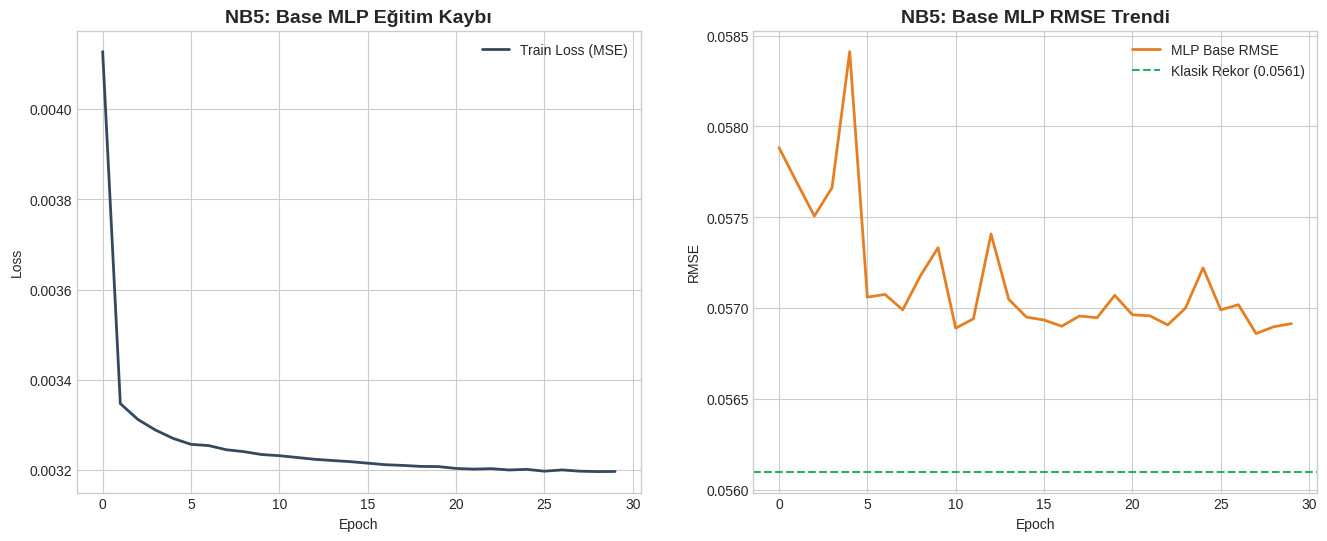

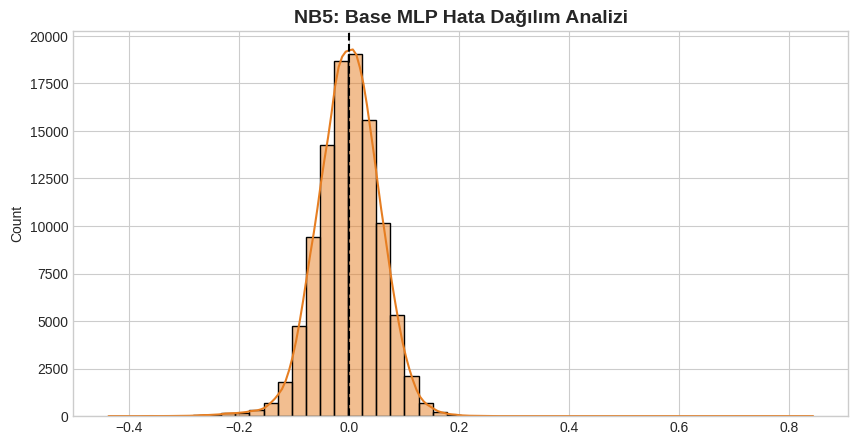

In [7]:
# --- FIGURES KLASÖRÜ HAZIRLIĞI ---
figures_path = os.path.join(base_path, 'figures')
os.makedirs(figures_path, exist_ok=True)

# 1. Eğitim ve Performans Grafikleri
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(train_losses, color='#34495E', linewidth=2, label='Train Loss (MSE)')
ax1.set_title('NB5: Base MLP Eğitim Kaybı', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend()

ax2.plot(val_rmses, color='#E67E22', linewidth=2, label='MLP Base RMSE')
ax2.axhline(y=0.0561, color='#27AE60', linestyle='--', label='Klasik Rekor (0.0561)')
ax2.set_title('NB5: Base MLP RMSE Trendi', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('RMSE'); ax2.legend()

# Kaydetme
plt.savefig(os.path.join(figures_path, '05_base_mlp_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

# 2. Hata Dağılımı (Residuals)
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='#E67E22', bins=50)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('NB5: Base MLP Hata Dağılım Analizi', fontsize=14, fontweight='bold')
plt.savefig(os.path.join(figures_path, '05_base_mlp_residuals.png'), dpi=300, bbox_inches='tight')
plt.show()